In [5]:
import pandas as pd

In [6]:
df = pd.read_csv("DCPop.csv", delimiter =";")

In [7]:
df.shape

(201, 1)

In [8]:
!ls

DCPop.csv       PROJECT2.ipynb  Untitled1.ipynb


In [9]:
df.head()

,Source Table: DECENNIALDDHCA2020.T01001
0,UNIVERSE CONSTANTS
1,"Population Groups:,""African American alone"""
2,"Geographic Area Name,""Total"""
3,"District of Columbia,""166,213"""
4,Census Tract 1.02; District of Columbia; Distr...


In [10]:
df.style.set_properties(**{
    'white-space': 'normal',
    'word-wrap': 'break-word'
})

,Source Table: DECENNIALDDHCA2020.T01001
0,UNIVERSE CONSTANTS
1,"Population Groups:,""African American alone"""
2,"Geographic Area Name,""Total"""
3,"District of Columbia,""166,213"""
4,"Census Tract 1.02; District of Columbia; District of Columbia,""38"""
5,"Census Tract 2.01; District of Columbia; District of Columbia,""127"""
6,"Census Tract 2.02; District of Columbia; District of Columbia,""82"""
7,"Census Tract 3; District of Columbia; District of Columbia,""112"""
8,"Census Tract 5.01; District of Columbia; District of Columbia,""117"""
9,"Census Tract 5.02; District of Columbia; District of Columbia,""52"""


# Meta Data & Structure 

#### 1. Remove the non-tabular metadata rows at the top (e.g., "Source Table: ...", "Universe Constants," Keeping only the header and data. 

In [11]:
with open("DCPop.csv") as f:
    for i in range(10):
        print(f.readline().strip())

﻿"Source Table: DECENNIALDDHCA2020.T01001"

"UNIVERSE CONSTANTS"
"Population Groups:","African American alone"

"Geographic Area Name","Total"
"District of Columbia","166,213"
"Census Tract 1.02; District of Columbia; District of Columbia","38"
"Census Tract 2.01; District of Columbia; District of Columbia","127"
"Census Tract 2.02; District of Columbia; District of Columbia","82"


In [12]:
df = pd.read_csv("DCPop.csv", skiprows=4)
df.head()

,Geographic Area Name,Total
0,District of Columbia,"166,213"
1,Census Tract 1.02; District of Columbia; Distr...,38
2,Census Tract 2.01; District of Columbia; Distr...,127
3,Census Tract 2.02; District of Columbia; Distr...,82
4,Census Tract 3; District of Columbia; District...,112


#### 2b. Confirm that the Header Row is Parsed as Two Fields: Geographic Area Name, Total.

In [13]:
df.columns

Index(['Geographic Area Name', 'Total'], dtype='object')

# Formatting & Parsing 

#### 1. Convert the Total column from a string with thousands separaters to a numeric integer type.

In [14]:
df['Total'] = df['Total'].replace(',', '', regex=True).astype(int)
df.head() 

,Geographic Area Name,Total
0,District of Columbia,166213
1,Census Tract 1.02; District of Columbia; Distr...,38
2,Census Tract 2.01; District of Columbia; Distr...,127
3,Census Tract 2.02; District of Columbia; Distr...,82
4,Census Tract 3; District of Columbia; District...,112


#### 2. Standardize Geographic Area Name (trim extra spaces and ensure consistent capitalization

In [15]:
df['Geographic Area Name'] = (
    df['Geographic Area Name']
    .str.strip()             
    .str.title()           
)
df.head()

,Geographic Area Name,Total
0,District Of Columbia,166213
1,Census Tract 1.02; District Of Columbia; Distr...,38
2,Census Tract 2.01; District Of Columbia; Distr...,127
3,Census Tract 2.02; District Of Columbia; Distr...,82
4,Census Tract 3; District Of Columbia; District...,112


#### 3. Extract the Census Tract ID into a New Column 

In [16]:
import pandas as pd
import re

df = pd.DataFrame({
    'description': ['Tract 1.02, District of Columbia, District of Columbia","38"', 
                   'Census Tract 2.01; District of Columbia; District of Columbia","127']
})

df['tract_id'] = df['description'].str.extract(r'Tract\s+([\d\.]+)')

print(df) 


df['tract_id'] = df['description'].str.extract(r'Tract\s+([\d\.]+)')
#making the data into a column

                                         description tract_id
0  Tract 1.02, District of Columbia, District of ...     1.02
1  Census Tract 2.01; District of Columbia; Distr...     2.01


#### 4. Parse and extract place/state information(E.G., District of Columbia) from Geographic Area Name into Separate columns.

In [17]:
df = pd.DataFrame({
    'Geographic Area Name': [
        'Tract 1.02, District of Columbia, District of Columbia',
        'Tract 2.01, District of Colombia, Disctrict of Colombia',
        'Tract 3.04, District of Colombia, District of Colombia'
    ]
})
df[['tract', 'place', 'state']] = df['Geographic Area Name'].str.split(',', expand=True, n=2)
print (df)

                                Geographic Area Name       tract  \
0  Tract 1.02, District of Columbia, District of ...  Tract 1.02   
1  Tract 2.01, District of Colombia, Disctrict of...  Tract 2.01   
2  Tract 3.04, District of Colombia, District of ...  Tract 3.04   

                   place                   state  
0   District of Columbia    District of Columbia  
1   District of Colombia   Disctrict of Colombia  
2   District of Colombia    District of Colombia  


# 3. Validation 

#### 1. Check for Missing Values in Total and Decide on Imputation or Exclusion Strategy. 

In [18]:
import pandas as pd
import re

# 1) Read the CSV starting at the real header (line with Geographic Area Name, Total)
df = pd.read_csv("DCPop.csv", skiprows=3, header=0, engine="python", dtype=str)

# 2) Normalize column names (strip spaces/quotes/BOM)
df.columns = (pd.Series(df.columns.astype(str))
              .str.replace('"', '', regex=False)
              .str.replace('\ufeff', '', regex=False)  # BOM, if present
              .str.strip())

# 3) Find columns robustly
# Try by name first
geo_col = next((c for c in df.columns if 'geographic' in c.lower() and 'name' in c.lower()), None)
tot_col = next((c for c in df.columns if 'total' in c.lower()), None)

# If not found, pick the column that looks most numeric as Total
if tot_col is None:
    pat = r'^\s*"?\d{1,3}(?:,\d{3})*(?:\.\d+)?\s*"?$'
    numeric_counts = df.apply(lambda s: s.astype(str).str.match(pat).sum())
    tot_col = numeric_counts.idxmax()

# If geo_col still None, choose the other column
if geo_col is None:
    geo_col = [c for c in df.columns if c != tot_col][0]

# 4) Keep and rename exactly
df = df[[geo_col, tot_col]].copy()
df.columns = ["Geographic Area Name", "Total"]

# 5) Clean values
df["Geographic Area Name"] = (df["Geographic Area Name"]
    .astype(str)
    .str.replace('"', '', regex=False)
    .str.strip()
)

df["Total"] = (df["Total"]
    .astype(str)
    .str.replace('"', '', regex=False)
    .str.replace(",", "", regex=False)
    .str.extract(r'(\d+(?:\.\d+)?)', expand=False)
    .astype(float)
)

# Impute any missing with median, then cast to int if whole numbers
df["Total"] = df["Total"].fillna(df["Total"].median())
if (df["Total"] % 1 == 0).all():
    df["Total"] = df["Total"].astype(int)

print("Final columns:", df.columns.tolist())
print(df.head(10))



Final columns: ['Geographic Area Name', 'Total']
                                Geographic Area Name   Total
0                               Geographic Area Name     567
1                               District of Columbia  166213
2  Census Tract 1.02; District of Columbia; Distr...      38
3  Census Tract 2.01; District of Columbia; Distr...     127
4  Census Tract 2.02; District of Columbia; Distr...      82
5  Census Tract 3; District of Columbia; District...     112
6  Census Tract 5.01; District of Columbia; Distr...     117
7  Census Tract 5.02; District of Columbia; Distr...      52
8  Census Tract 6; District of Columbia; District...     115
9  Census Tract 7.02; District of Columbia; Distr...     127


#### 2. Identify and Remove duplicate Tracts (duplicate Geographic Area Name or extracted tract IDs). 

In [19]:
import pandas as pd
import numpy as np

# 1) Ensure 'tract' exists (e.g., "Census Tract 1.02" -> "1.02")
df['tract'] = df['Geographic Area Name'].str.extract(r'Census Tract\s*([\d\.]+)', expand=False)

# 2) (Optional) If you haven’t already created place/state, do it now.
#    This helps ensure we only compare tracts *within the same place/state*.
if 'place' not in df.columns or 'state' not in df.columns:
    parts = df['Geographic Area Name'].str.split(';')
    df['state'] = parts.str[-1].str.strip().str.title()
    df['place'] = parts.str[-2].str.strip().str.title()
    df['place'] = df['place'].fillna(df['state'])

# 3) Identify duplicates
dups_by_name  = df[df.duplicated('Geographic Area Name', keep=False)].sort_values('Geographic Area Name')
dups_by_tract = df[df['tract'].notna() & df.duplicated(['state','place','tract'], keep=False)] \
                  .sort_values(['state','place','tract'])

print("Duplicate rows by full Geographic Area Name:", len(dups_by_name))
print("Duplicate rows by (state, place, tract):", len(dups_by_tract))

# (Optional) Peek:
# display(dups_by_name.head(10))
# display(dups_by_tract.head(10))

# 4) Remove duplicates
# Strategy: within each (state, place, tract), keep the row with the **largest Total**.
# For rows without a tract (e.g., the overall "District of Columbia" row), we dedupe by full name.
df_clean = df.copy()

# a) Drop exact-name duplicates, keeping the one with largest Total
df_clean = (df_clean
            .sort_values(['Geographic Area Name','Total'], ascending=[True, False])
            .drop_duplicates(subset=['Geographic Area Name'], keep='first'))

# b) For tract-level duplicates within the same place/state, keep the one with largest Total
has_tract = df_clean['tract'].notna()
df_with_tract = (df_clean[has_tract]
                 .sort_values(['state','place','tract','Total'], ascending=[True, True, True, False])
                 .drop_duplicates(subset=['state','place','tract'], keep='first'))

df_without_tract = df_clean[~has_tract]

# c) Recombine
df_deduped = pd.concat([df_with_tract, df_without_tract], ignore_index=True)

# 5) Final checks
print("Original rows:", len(df))
print("After de-duplication:", len(df_deduped))
# Peek at results
df_deduped.head(10)

Duplicate rows by full Geographic Area Name: 0
Duplicate rows by (state, place, tract): 0
Original rows: 199
After de-duplication: 199


,Geographic Area Name,Total,tract,state,place
0,Census Tract 1.02; District of Columbia; Distr...,38,1.02,District Of Columbia,District Of Columbia
1,Census Tract 10.02; District of Columbia; Dist...,150,10.02,District Of Columbia,District Of Columbia
2,Census Tract 10.03; District of Columbia; Dist...,37,10.03,District Of Columbia,District Of Columbia
3,Census Tract 10.04; District of Columbia; Dist...,105,10.04,District Of Columbia,District Of Columbia
4,Census Tract 101; District of Columbia; Distri...,252,101,District Of Columbia,District Of Columbia
5,Census Tract 102.01; District of Columbia; Dis...,548,102.01,District Of Columbia,District Of Columbia
6,Census Tract 102.02; District of Columbia; Dis...,371,102.02,District Of Columbia,District Of Columbia
7,Census Tract 103; District of Columbia; Distri...,1007,103,District Of Columbia,District Of Columbia
8,Census Tract 104; District of Columbia; Distri...,2717,104,District Of Columbia,District Of Columbia
9,Census Tract 105; District of Columbia; Distri...,823,105,District Of Columbia,District Of Columbia


#### 3. Verify that the sum of all tract populations equals the district total (e.g., 166,213); report any discrepancy.

#### 3. Verify that the sum of all tract populations equals the district total, verify any discrepancy. 

In [20]:
# Step 1: Identify the district-level total row
district_row = df[df['Geographic Area Name'].str.lower().str.strip() == 'district of columbia']

# Step 2: Extract the district's official total
district_total = district_row['Total'].sum() if not district_row.empty else None

# Step 3: Compute the sum of all tract populations (exclude district-level row)
tract_sum = df[~df['Geographic Area Name'].str.lower().str.strip().eq('district of columbia')]['Total'].sum()

# Step 4: Compare and verify
print(f"District total (from file): {district_total:,.0f}")
print(f"Sum of all tracts:          {tract_sum:,.0f}")
print(f"Discrepancy:                {tract_sum - district_total:,.0f}")


District total (from file): 166,213
Sum of all tracts:          160,060
Discrepancy:                -6,153


# New Features & Summaries 

#### 1. Create a population share column: each tract's as a percentage of the district total.

In [25]:
# Drop the first two rows that are headers or totals
df = df.drop([0, 1]).reset_index(drop=True)

# Convert 'Total' column to numeric (since it may be stored as text)
df["Total"] = pd.to_numeric(df["Total"], errors="coerce")

# Recalculate the population share
df["PopShare"] = df["Total"] / df["Total"].sum() * 100

# Display first few rows
df.head()

,Geographic Area Name,Total,tract,state,place,PopShare
0,Census Tract 1.02; District of Columbia; Distr...,38,1.02,District Of Columbia,District Of Columbia,0.023825
1,Census Tract 2.01; District of Columbia; Distr...,127,2.01,District Of Columbia,District Of Columbia,0.079627
2,Census Tract 2.02; District of Columbia; Distr...,82,2.02,District Of Columbia,District Of Columbia,0.051413
3,Census Tract 3; District of Columbia; District...,112,3,District Of Columbia,District Of Columbia,0.070223
4,Census Tract 5.01; District of Columbia; Distr...,117,5.01,District Of Columbia,District Of Columbia,0.073357


In [24]:
print(df.head())

                                Geographic Area Name   Total tract  \
0                               Geographic Area Name     567   NaN   
1                               District of Columbia  166213   NaN   
2  Census Tract 1.02; District of Columbia; Distr...      38  1.02   
3  Census Tract 2.01; District of Columbia; Distr...     127  2.01   
4  Census Tract 2.02; District of Columbia; Distr...      82  2.02   

                  state                 place   PopShare  
0  Geographic Area Name  Geographic Area Name   0.173781  
1  District Of Columbia  District Of Columbia  50.942922  
2  District Of Columbia  District Of Columbia   0.011647  
3  District Of Columbia  District Of Columbia   0.038924  
4  District Of Columbia  District Of Columbia   0.025132  


#### Bucket Tracts by Population Size (e.g., Small<50, Medium 50-150, Large> 150) and count tracts per bucket.

In [28]:
#### Bucket tracts by population size (Small <50, Medium 50–150, Large >150) and count tracts per bucket
bins = [0, 50, 150, float("inf")]  # define population cutoffs
labels = ["Small", "Medium", "Large"]  # bucket names
df["PopBucket"] = pd.cut(df["Total"], bins=bins, labels=labels)  # assign each tract to a bucket
bucket_counts = df["PopBucket"].value_counts()  # count number of tracts per bucket
print(bucket_counts)

PopBucket
Large     152
Medium     41
Small       4
Name: count, dtype: int64


#### Sort Tracts by Population and list the top 5 Most poulated tracts name and count)

<Axes: title={'center': 'Number of Tracts by Population Size'}, xlabel='PopBucket'>

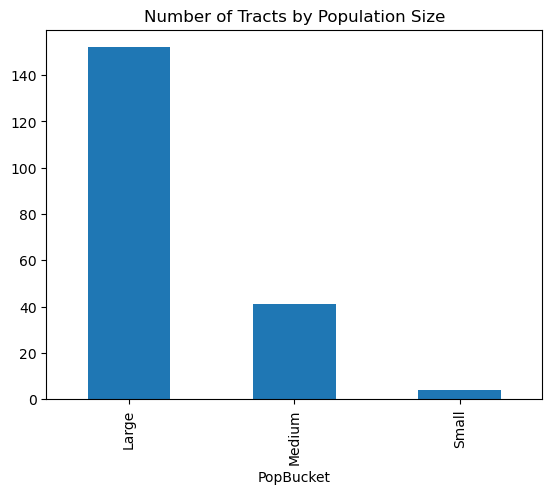

In [30]:
bucket_counts.plot(kind="bar", title="Number of Tracts by Population Size")